# SnorkelStreaming concept drift adaption

Install necessary libraries

In [49]:
!pip install numpy
!pip install pandas
!pip install torch
!pip install snorkel

In [50]:
import warnings
warnings.filterwarnings("ignore")

Mount Google Drive

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load electricity data

In [52]:
import pandas as pd

data_filename = '/content/drive/My Drive/SnorkelStreaming/data/elec2_data.dat'
label_filename = '/content/drive/My Drive/SnorkelStreaming/data/elec2_label.dat'
data_df = pd.read_csv(data_filename, header=None, names=['date', 'day', 'peorid', 'nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer'], sep='\s+').drop(['date'], axis=1)
label_df = pd.read_csv(label_filename, header=None, names=['label'])

# Display the DataFrame
label_df.head()

,label
0,0
1,0
2,0
3,0
4,1


In [53]:
data_df.head()

,day,peorid,nswprice,nswdemand,vicprice,vicdemand,transfer
0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912
1,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912
2,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912
3,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912
4,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912


In [54]:
data_df.describe()

,day,peorid,nswprice,nswdemand,vicprice,vicdemand,transfer
count,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000
mean,4.003178,0.500000,0.057868,0.425418,0.003467,0.422915,0.500526
std,1.998695,0.294756,0.039991,0.163323,0.010213,0.120965,0.153373
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.250000,0.035127,0.309134,0.002277,0.372346,0.414912
50%,4.000000,0.500000,0.048652,0.443693,0.003467,0.422915,0.414912
75%,6.000000,0.750000,0.074336,0.536001,0.003467,0.469252,0.605702
max,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Install River library

In [55]:
!pip install river

In [56]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df = pd.concat([data_df, label_df], axis=1)

df.describe()

,day,peorid,nswprice,nswdemand,vicprice,vicdemand,transfer,label
count,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000
mean,4.003178,0.500000,0.057868,0.425418,0.003467,0.422915,0.500526,0.575455
std,1.998695,0.294756,0.039991,0.163323,0.010213,0.120965,0.153373,0.494279
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.250000,0.035127,0.309134,0.002277,0.372346,0.414912,0.000000
50%,4.000000,0.500000,0.048652,0.443693,0.003467,0.422915,0.414912,1.000000
75%,6.000000,0.750000,0.074336,0.536001,0.003467,0.469252,0.605702,1.000000
max,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [57]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import auc, confusion_matrix

DOWN = 0
UP = 1

train_idx = 1000

train = df[:train_idx]
x_train, y_train = train.drop('label', axis=1), train['label']

feature_names = x_train.columns.tolist()

classifier = LogisticRegression(solver='liblinear')
classifier.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

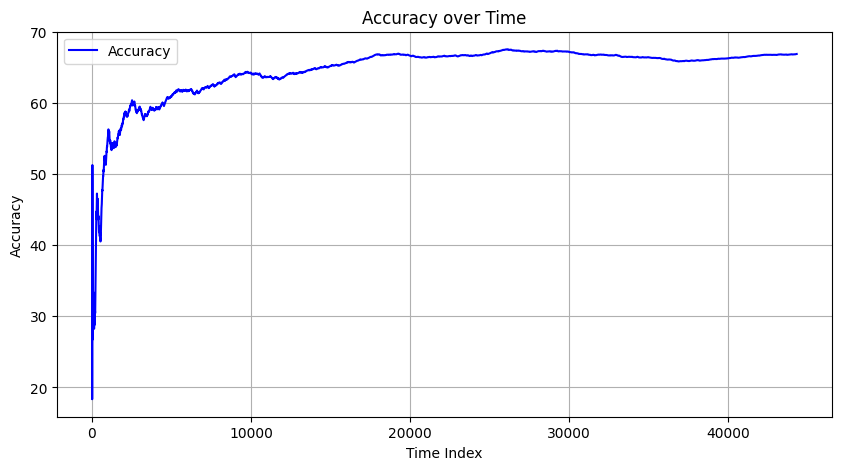

In [58]:
acc = []
stream = df[train_idx:]
total = correct = 0
for _, dp in stream.iterrows():
  x = dp[feature_names].values.reshape(1, -1)
  y = dp['label']

  y_predict=classifier.predict(x)

  total += 1
  correct += 1 if y_predict == y else 0

  acc.append(correct/total * 100)

smoothed_acc = pd.Series(acc).rolling(window=10).mean()

# Acc
plt.figure(figsize=(10, 5))
plt.plot(smoothed_acc, label='Accuracy', color='blue')
plt.xlabel('Time Index')
plt.ylabel('Accuracy')
plt.title('Accuracy over Time')
plt.legend()
plt.grid(True)
plt.show()

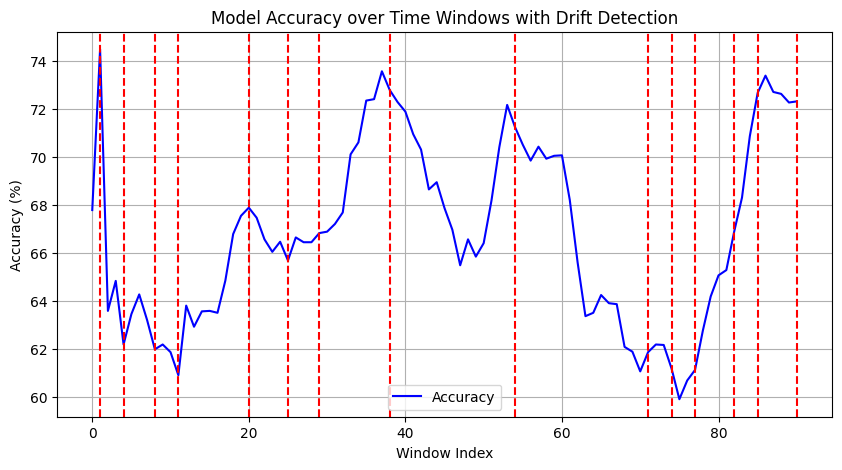

In [59]:
from river import drift
import matplotlib.pyplot as plt
import pandas as pd

drift_detector = drift.ADWIN(delta=0.005)
drifts = set()

window_size = 500
static_acc = []

idx = 0
for window_start in range(0, len(df), window_size):
    window_end = window_start + window_size
    window_data = df.iloc[window_start:window_end]

    if len(window_data) == 0:
        break

    X_window = window_data[feature_names]
    y_window = window_data['label']

    for _, elem in X_window.iterrows():
        drift_detector.update(elem['nswprice'])
        if drift_detector.drift_detected:
          drifts.add(idx)

    y_pred = classifier.predict(X_window)

    correct = np.sum(y_pred == y_window)
    accuracy = correct / len(window_data) * 100
    static_acc.append(accuracy)

    idx += 1

static_acc = pd.Series(static_acc).rolling(window=10, min_periods=1).mean()

plt.figure(figsize=(10, 5))
plt.plot(static_acc, label='Accuracy', color='blue')

for drift_idx in list(drifts):
    plt.axvline(x=drift_idx, color='red', linestyle='--')

plt.xlabel('Window Index')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy over Time Windows with Drift Detection')
plt.legend()
plt.grid(True)
plt.show()


## Let's use SnorkelStreaming

In [60]:
df.describe()

,day,peorid,nswprice,nswdemand,vicprice,vicdemand,transfer,label
count,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000
mean,4.003178,0.500000,0.057868,0.425418,0.003467,0.422915,0.500526,0.575455
std,1.998695,0.294756,0.039991,0.163323,0.010213,0.120965,0.153373,0.494279
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.250000,0.035127,0.309134,0.002277,0.372346,0.414912,0.000000
50%,4.000000,0.500000,0.048652,0.443693,0.003467,0.422915,0.414912,1.000000
75%,6.000000,0.750000,0.074336,0.536001,0.003467,0.469252,0.605702,1.000000
max,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
train_idx = 1000

train = df[:train_idx]
x_train, y_train = train.drop('label', axis=1), train['label']

feature_names = x_train.columns.tolist()

In [62]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

DOWN = 0
UP = 1

snorkel_log_classifier = LogisticRegression(solver='liblinear')
snorkel_log_classifier.fit(x_train, y_train)

snorkel_svc_classifier = SVC(probability=True)
snorkel_svc_classifier.fit(x_train, y_train)

snorkel_rf_classifier = RandomForestClassifier()
snorkel_rf_classifier.fit(x_train, y_train)

snorkel_mlp_classifier = MLPClassifier()
snorkel_mlp_classifier.fit(x_train, y_train)

classifiers = [snorkel_svc_classifier, snorkel_rf_classifier, snorkel_mlp_classifier]
print(classifiers)

[SVC(probability=True), RandomForestClassifier(), MLPClassifier()]


In [63]:
from snorkel.labeling import labeling_function

def wrap_labeling_function(model):
    name = f"{type(model)}"
    @labeling_function(name=name)
    def lf(x):
        x_reshaped = x.values.reshape(1, -1)
        return model.predict(x_reshaped)[0]
    return lf

lfs = [wrap_labeling_function(classifier) for classifier in classifiers]

In [64]:
from snorkel.labeling import PandasLFApplier
from snorkel.labeling.model import LabelModel

applier = PandasLFApplier(lfs=lfs)

L_train = applier.apply(x_train)

label_model = LabelModel(cardinality=2)

label_model.fit(L_train=L_train, n_epochs=1000)

100%|██████████| 1000/1000 [00:03<00:00, 325.00epoch/s]


In [65]:
from sklearn.linear_model import SGDClassifier

orig_classifier = SGDClassifier(loss="log_loss")

y_train = label_model.predict(L=L_train, tie_break_policy="abstain")

orig_classifier.partial_fit(x_train, y_train, classes=[UP, DOWN])

SGDClassifier(loss='log_loss')

100%|██████████| 312/312 [00:01<00:00, 168.07it/s]


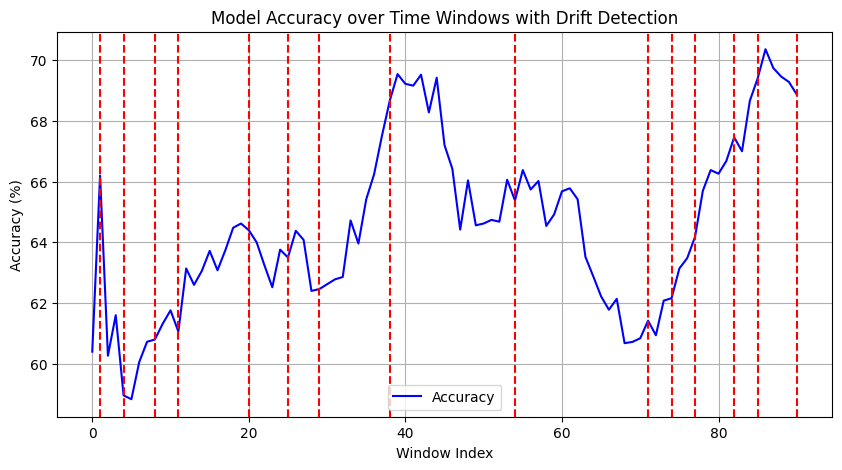

In [66]:
from river import drift
import matplotlib.pyplot as plt
import pandas as pd

drift_detector = drift.ADWIN(delta=0.005)
drifts = set()

window_size = 500
orig_snorkel_acc = []

idx = 0
for window_start in range(0, len(df), window_size):
    window_end = window_start + window_size
    window_data = df.iloc[window_start:window_end]

    if len(window_data) == 0:
        break

    X_window = window_data[feature_names]
    L = applier.apply(X_window)
    y_window = label_model.predict(L=L, tie_break_policy="abstain")
    orig_classifier.partial_fit(X_window, y_window, classes=[UP, DOWN])

    y_true = window_data['label']

    for _, elem in X_window.iterrows():
        drift_detector.update(elem['nswprice'])
        if drift_detector.drift_detected:
          drifts.add(idx)

    y_pred = orig_classifier.predict(X_window)

    correct = np.sum(y_pred == y_true)
    accuracy = correct / len(window_data) * 100
    orig_snorkel_acc.append(accuracy)

    idx += 1

orig_snorkel_acc = pd.Series(orig_snorkel_acc).rolling(window=10, min_periods=1).mean()

plt.figure(figsize=(10, 5))
plt.plot(orig_snorkel_acc, label='Accuracy', color='blue')

for drift_idx in list(drifts):
    plt.axvline(x=drift_idx, color='red', linestyle='--')

plt.xlabel('Window Index')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy over Time Windows with Drift Detection')
plt.legend()
plt.grid(True)
plt.show()

## Increamental Learning Snorkel

In [67]:
from typing import Any, Optional, List
import numpy as np
from numpy import ndarray
import torch
from snorkel.labeling.model import LabelModel
import logging

class IncLabelModel(LabelModel):
    """
    Incremental Label Model for semi-supervised learning.

    This class extends the base `LabelModel` class and provides additional functionality
    for incremental training and updating of the label model.

    Args:
        cardinality (int): The number of classes. Defaults to 2.
        **kwargs: Additional keyword arguments to be passed to the base `LabelModel` class.

    Attributes:
        n_total (int): The total number of training examples seen so far.

    Methods:
        _generate_O: Generates the matrix O used for training.
        fit: Fits the label model to the training data.
        incremental_fit: Performs incremental training on the label model.
    """

    def __init__(self, cardinality: int = 2, **kwargs: Any) -> None:
        super().__init__(cardinality, **kwargs)
        self.n_total = 0

    def _generate_O(self, L: ndarray, higher_order: bool = False, O_old: Optional[torch.Tensor] = None) -> None:
        """
        Generates the matrix O used for training.

        Args:
            L (ndarray): The label matrix.
            higher_order (bool): Whether to use higher-order dependencies. Defaults to False.
            O_old (Optional[torch.Tensor]): The previous matrix O. Defaults to None.
        """
        L_aug = self._get_augmented_label_matrix(L, higher_order=higher_order)
        self.d = L_aug.shape[1]
        O_new = torch.from_numpy(L_aug.T @ L_aug / L.shape[0]).float().to(self.config.device)

        if O_old is not None:
            # Calculate the weight of old and new O
            w_old = O_old.shape[0] / (O_old.shape[0] + L.shape[0])
            w_new = L.shape[0] / (O_old.shape[0] + L.shape[0])
            self.O = w_old * O_old + w_new * O_new
        else:
            self.O = O_new

    def fit(self, L_train: ndarray, Y_dev: ndarray | None = None, class_balance: List[float] | None = None, progress_bar: bool = True, **kwargs: Any) -> None:
        """
        Fits the label model to the training data.

        Args:
            L_train (ndarray): The training label matrix.
            Y_dev (ndarray | None): The development label matrix. Defaults to None.
            class_balance (List[float] | None): The class balance weights. Defaults to None.
            progress_bar (bool): Whether to display a progress bar. Defaults to True.
            **kwargs: Additional keyword arguments to be passed to the base `fit` method.
        """
        self.n_total += L_train.shape[0]
        super().fit(L_train, Y_dev, class_balance, progress_bar, **kwargs)

    def incremental_fit(
        self,
        L_train: ndarray,
        Y_dev: Optional[ndarray] = None,
        class_balance: Optional[List[float]] = None,
        **kwargs: Any,
    ) -> None:
        """
        Performs incremental training on the label model.

        Args:
            L_train (ndarray): The training label matrix.
            Y_dev (Optional[ndarray]): The development label matrix. Defaults to None.
            class_balance (Optional[List[float]]): The class balance weights. Defaults to None.
            **kwargs: Additional keyword arguments to be passed to the base `incremental_fit` method.
        """
        self.n_total += L_train.shape[0]

        L_shift = L_train + 1
        if L_shift.max() > self.cardinality:
            raise ValueError(
                f"L_train has cardinality {L_shift.max()}, but cardinality={self.cardinality} was passed in."
            )
        self._set_constants(L_shift)

        if class_balance is not None:
            self._set_class_balance(class_balance, Y_dev)

        self._generate_O(L_shift, O_old=self.O)

        # if self.train_config.mu_eps is None:
        #     self.train_config.mu_eps = min(0.01, 1 / 10 ** np.ceil(np.log10(self.n_total)))

        for key, value in kwargs.items():
            if hasattr(self.train_config, key):
                setattr(self.train_config, key, value)

        if hasattr(self, 'optimizer'):
            self._set_optimizer()
        if hasattr(self, 'lr_scheduler'):
            self._set_lr_scheduler()

        self.train()
        self.to(self.config.device)

        for epoch in range(self.train_config.n_epochs):
            self.running_loss = 0.0
            self.running_examples = 0

            self.optimizer.zero_grad()
            loss = self._loss_mu(l2=self.train_config.l2)
            if torch.isnan(loss):
                logging.error("Loss is NaN. Consider reducing learning rate.")
                break
            loss.backward()
            self.optimizer.step()
            self._execute_logging(loss)
            self._update_lr_scheduler(epoch)

        self._clamp_params()
        self.eval()

        if self.config.verbose:
            logging.info("Finished Incremental Training")


In [68]:
inc_label_model = IncLabelModel(cardinality=2)

inc_label_model.fit(L_train=L_train, n_epochs=1000)

100%|██████████| 1000/1000 [00:01<00:00, 844.62epoch/s]


In [69]:
from sklearn.linear_model import SGDClassifier

inc_classifier = SGDClassifier(loss="log_loss")

y_train = inc_label_model.predict(L=L_train, tie_break_policy="abstain")

inc_classifier.partial_fit(x_train, y_train, classes=[UP, DOWN])

SGDClassifier(loss='log_loss')

100%|██████████| 312/312 [00:02<00:00, 122.07it/s]


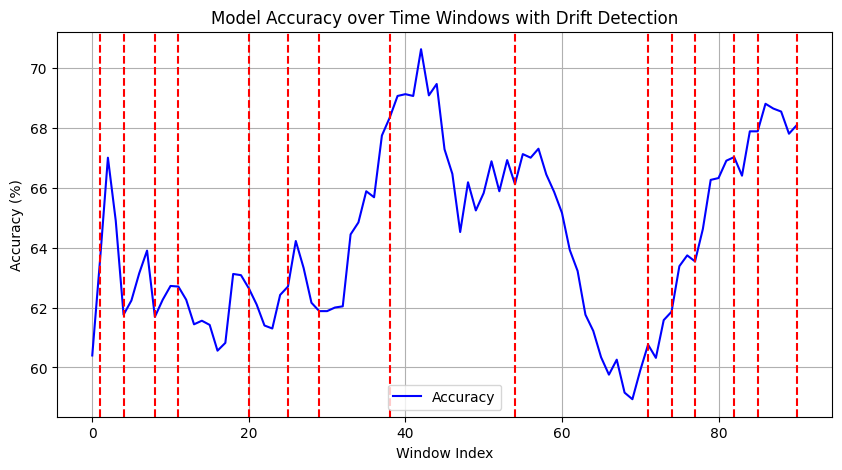

In [70]:
from river import drift
import matplotlib.pyplot as plt
import pandas as pd

drift_detector = drift.ADWIN(delta=0.005)
drifts = set()

window_size = 500
inc_snorkel_acc = []

idx = 0
for window_start in range(0, len(df), window_size):
    window_end = window_start + window_size
    window_data = df.iloc[window_start:window_end]

    if len(window_data) == 0:
        break

    X_window = window_data[feature_names]
    L = applier.apply(X_window)
    inc_label_model.incremental_fit(L)
    y_window = inc_label_model.predict(L=L, tie_break_policy="abstain")
    inc_classifier.partial_fit(X_window, y_window, classes=[UP, DOWN])

    y_true = window_data['label']

    for _, elem in X_window.iterrows():
        drift_detector.update(elem['nswprice'])
        if drift_detector.drift_detected:
          drifts.add(idx)

    y_pred = inc_classifier.predict(X_window)

    correct = np.sum(y_pred == y_true)
    accuracy = correct / len(window_data) * 100
    inc_snorkel_acc.append(accuracy)

    idx += 1

inc_snorkel_acc = pd.Series(inc_snorkel_acc).rolling(window=10, min_periods=1).mean()

plt.figure(figsize=(10, 5))
plt.plot(inc_snorkel_acc, label='Accuracy', color='blue')

for drift_idx in list(drifts):
    plt.axvline(x=drift_idx, color='red', linestyle='--')

plt.xlabel('Window Index')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy over Time Windows with Drift Detection')
plt.legend()
plt.grid(True)
plt.show()

## Completely retrain Snorkel

In [71]:
retrain_label_model = LabelModel(cardinality=2)
retrain_label_model.fit(L_train=L_train, n_epochs=1000)

100%|██████████| 1000/1000 [00:01<00:00, 854.17epoch/s]


In [72]:
from sklearn.linear_model import SGDClassifier

retrain_classifier = SGDClassifier(loss="log_loss")

y_train = retrain_label_model.predict(L=L_train, tie_break_policy="abstain")

retrain_classifier.partial_fit(x_train, y_train, classes=[UP, DOWN])

SGDClassifier(loss='log_loss')

100%|██████████| 1000/1000 [00:01<00:00, 647.49epoch/s]


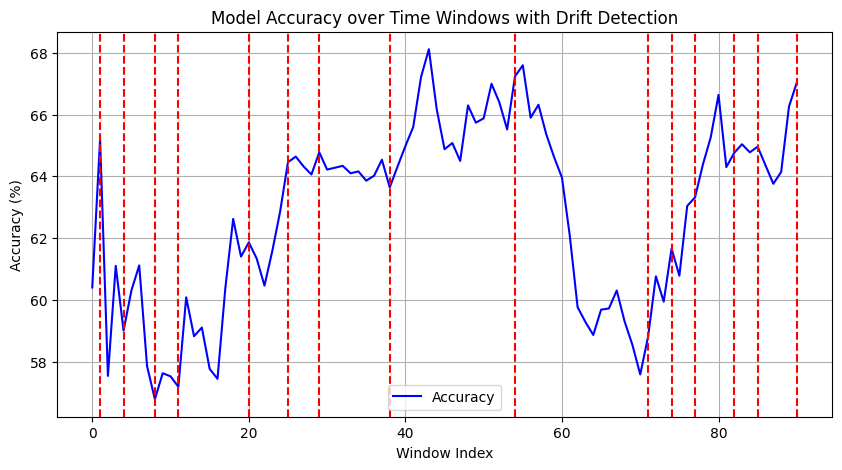

In [73]:
from river import drift
import matplotlib.pyplot as plt
import pandas as pd

drift_detector = drift.ADWIN(delta=0.005)
drifts = set()

window_size = 500
retrain_snorkel_acc = []

idx = 0
for window_start in range(0, len(df), window_size):
    window_end = window_start + window_size
    window_data = df.iloc[window_start:window_end]

    if len(window_data) == 0:
        break

    X_window = window_data[feature_names]
    L = applier.apply(X_window)

    for _, elem in X_window.iterrows():
        drift_detector.update(elem['nswprice'])
        if drift_detector.drift_detected:
          drifts.add(idx)
          retrain_label_model.fit(L_train=L, n_epochs=1000)


    y_window = retrain_label_model.predict(L=L, tie_break_policy="abstain")
    retrain_classifier.partial_fit(X_window, y_window, classes=[UP, DOWN])

    y_true = window_data['label']

    y_pred = retrain_classifier.predict(X_window)

    correct = np.sum(y_pred == y_true)
    accuracy = correct / len(window_data) * 100
    retrain_snorkel_acc.append(accuracy)

    idx += 1

retrain_snorkel_acc = pd.Series(retrain_snorkel_acc).rolling(window=10, min_periods=1).mean()

plt.figure(figsize=(10, 5))
plt.plot(retrain_snorkel_acc, label='Accuracy', color='blue')

for drift_idx in list(drifts):
    plt.axvline(x=drift_idx, color='red', linestyle='--')

plt.xlabel('Window Index')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy over Time Windows with Drift Detection')
plt.legend()
plt.grid(True)
plt.show()

## MetaModel for Snorkel

In [74]:
from snorkel.labeling import labeling_function, PandasLFApplier, LFApplier
from snorkel.labeling.model import LabelModel
from collections import deque
import pandas as pd
import numpy as np
from typing import List, Callable, Union, Sequence, Any
from scipy.stats import mode

class MetaLabelModel:
    """
    A meta-label model that combines multiple LabelModels for prediction.

    Args:
        cardinality (int): The number of classes for the label.
        lfs (List[Callable]): List of labeling functions to be applied.
        max_models (int, optional): Maximum number of LabelModels to keep. Defaults to 3.
        data_mode (str, optional): Data mode, either 'seq' for sequence data or 'df' for DataFrame data. Defaults to 'seq'.
        n_epochs (int, optional): Number of training epochs for each LabelModel. Defaults to 500.
    """

    def __init__(
        self,
        cardinality: int,
        lfs: List[Callable],
        max_models: int=3,
        data_mode: str='seq',
        n_epochs: int=500
    ) -> None:
        assert data_mode in ['seq', 'df']
        self.applier = LFApplier(lfs=lfs) if data_mode == 'seq' else PandasLFApplier(lfs=lfs)
        self.cardinality = cardinality
        assert max_models >= 3, "max_model must be at least 3"
        self.models = deque(maxlen=max_models)
        self.data_mode = data_mode
        self.n_epochs = n_epochs
        self.meta_model = None
        self.mode = 'vote'

    def update(self, data: Union[Sequence[Any], pd.DataFrame]) -> None:
        """
        Update the meta-label model with new data.

        Args:
            data (Union[Sequence[Any], pd.DataFrame]): The input data for updating the model.
        """
        assert self.data_mode == 'seq' or isinstance(data, pd.DataFrame), \
            "Data must be a DataFrame when using dataframe mode"

        # Add new model to models queue
        new_model = LabelModel(cardinality=self.cardinality)
        L_train = self.applier.apply(data)
        new_model.fit(L_train=L_train, n_epochs=self.n_epochs)
        print("new snorkel model trained!")

        self.models.append(new_model)
        if len(self.models) >= 3:
            self.mode = 'meta'
            print("now in meta mode, meta model training...")
            self._train_meta_model(data)
            print("meta model trained!")

    def predict(self, data: Union[Sequence[Any], pd.DataFrame]) -> np.ndarray:
        """
        Predict labels for the input data.

        Args:
            data (Union[Sequence[Any], pd.DataFrame]): The input data for prediction.

        Returns:
            np.ndarray: The predicted labels.
        """
        assert len(self.models) > 0, "No models available for prediction"
        assert self.data_mode == 'seq' or isinstance(data, pd.DataFrame), \
            "Data must be a DataFrame when using dataframe mode"

        if self.mode == 'vote':
            L = self.applier.apply(data)
            predictions = []
            for m in self.models:
                predictions.append(m.predict(L))
            predictions = np.vstack(predictions)
            mode_result, _ = mode(predictions, axis=0)
            final_predictions = mode_result.squeeze()
            return final_predictions

        elif self.mode == 'meta':
            assert len(self.models) >= 3, f"There must be at least three models when using meta, current {len(self.models)} models"
            assert self.meta_model, "Meta model not trained yet."

            L = self._meta_apply(data)
            return self.meta_model.predict(L)

        else:
            raise ValueError('Invalid mode')

    def _meta_apply(self, data: Union[Sequence[Any], pd.DataFrame]) -> ndarray:
        orig_L = self.applier.apply(data)
        preds = []
        for model in self.models:
            preds.append(model.predict(L=orig_L))
        preds_array = np.array(preds)
        L = preds_array.T
        return L

    def _train_meta_model(self, data: Union[Sequence[Any], pd.DataFrame]) -> None:
        """
        Train the meta-label model using the existing LabelModels.

        Args:
            data (Union[Sequence[Any], pd.DataFrame]): The input data for training the meta-label model.
        """
        self.meta_model = LabelModel(cardinality=self.cardinality)
        L_train = self._meta_apply(data)
        self.meta_model.fit(L_train=L_train, n_epochs=self.n_epochs)

In [75]:
from sklearn.linear_model import SGDClassifier

meta_classifier = SGDClassifier(loss="log_loss")

y_train = retrain_label_model.predict(L=L_train, tie_break_policy="abstain")

meta_classifier.partial_fit(x_train, y_train, classes=[UP, DOWN])

SGDClassifier(loss='log_loss')

In [76]:
meta_model = MetaLabelModel(cardinality=2, lfs=lfs, data_mode='df', n_epochs=1000)

meta_model.update(x_train)

100%|██████████| 1000/1000 [00:01<00:00, 846.53epoch/s]

new snorkel model trained!


100%|██████████| 1000/1000 [00:01<00:00, 873.98epoch/s]


new snorkel model trained!


100%|██████████| 1000/1000 [00:01<00:00, 742.14epoch/s]


new snorkel model trained!
now in meta mode, meta model training...


100%|██████████| 1000/1000 [00:01<00:00, 865.62epoch/s]


meta model trained!


100%|██████████| 1000/1000 [00:01<00:00, 852.01epoch/s]


new snorkel model trained!
now in meta mode, meta model training...


100%|██████████| 1000/1000 [00:01<00:00, 747.13epoch/s]


meta model trained!


100%|██████████| 1000/1000 [00:01<00:00, 604.46epoch/s]


new snorkel model trained!
now in meta mode, meta model training...


100%|██████████| 1000/1000 [00:01<00:00, 868.48epoch/s]


meta model trained!


100%|██████████| 1000/1000 [00:01<00:00, 863.29epoch/s]


new snorkel model trained!
now in meta mode, meta model training...


100%|██████████| 1000/1000 [00:01<00:00, 868.40epoch/s]


meta model trained!


100%|██████████| 1000/1000 [00:01<00:00, 853.63epoch/s]


new snorkel model trained!
now in meta mode, meta model training...


100%|██████████| 1000/1000 [00:01<00:00, 752.57epoch/s]


meta model trained!


100%|██████████| 1000/1000 [00:01<00:00, 623.48epoch/s]


new snorkel model trained!
now in meta mode, meta model training...


100%|██████████| 1000/1000 [00:01<00:00, 838.77epoch/s]


meta model trained!


100%|██████████| 1000/1000 [00:01<00:00, 742.94epoch/s]


new snorkel model trained!
now in meta mode, meta model training...


100%|██████████| 1000/1000 [00:01<00:00, 860.01epoch/s]


meta model trained!


100%|██████████| 1000/1000 [00:01<00:00, 506.05epoch/s]


new snorkel model trained!
now in meta mode, meta model training...


100%|██████████| 1000/1000 [00:01<00:00, 859.82epoch/s]


meta model trained!


100%|██████████| 1000/1000 [00:01<00:00, 762.86epoch/s]


new snorkel model trained!
now in meta mode, meta model training...


100%|██████████| 1000/1000 [00:01<00:00, 843.02epoch/s]


meta model trained!


100%|██████████| 1000/1000 [00:01<00:00, 641.52epoch/s]


new snorkel model trained!
now in meta mode, meta model training...


100%|██████████| 1000/1000 [00:01<00:00, 865.41epoch/s]


meta model trained!


100%|██████████| 1000/1000 [00:01<00:00, 617.85epoch/s]


new snorkel model trained!
now in meta mode, meta model training...


100%|██████████| 1000/1000 [00:01<00:00, 847.50epoch/s]


meta model trained!


100%|██████████| 1000/1000 [00:01<00:00, 742.37epoch/s]


new snorkel model trained!
now in meta mode, meta model training...


100%|██████████| 1000/1000 [00:01<00:00, 844.95epoch/s]


meta model trained!


100%|██████████| 1000/1000 [00:01<00:00, 855.96epoch/s]


new snorkel model trained!
now in meta mode, meta model training...


100%|██████████| 1000/1000 [00:01<00:00, 770.28epoch/s]


meta model trained!


100%|██████████| 1000/1000 [00:01<00:00, 856.03epoch/s]


new snorkel model trained!
now in meta mode, meta model training...


100%|██████████| 1000/1000 [00:01<00:00, 613.46epoch/s]


meta model trained!


100%|██████████| 312/312 [00:02<00:00, 122.91it/s]


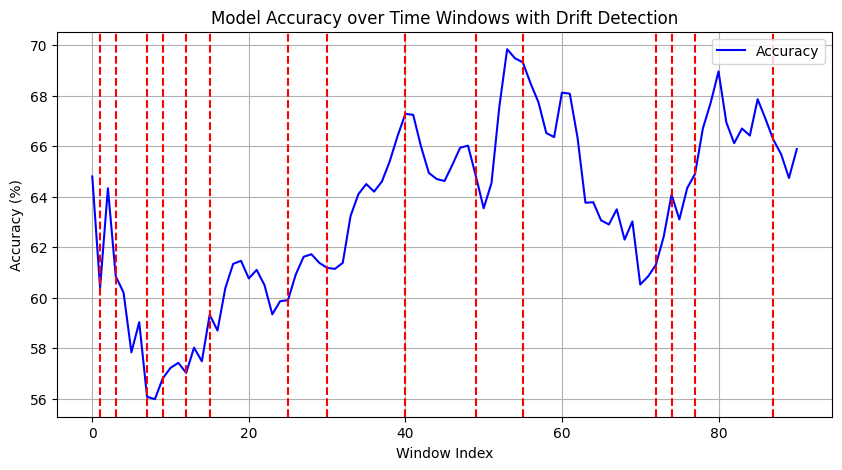

In [77]:
from river import drift
import matplotlib.pyplot as plt
import pandas as pd

drift_detector = drift.ADWIN(delta=0.005)
drifts = set()

window_size = 500
meta_acc = []

idx = 0
for window_start in range(0, len(df), window_size):
    window_end = window_start + window_size
    window_data = df.iloc[window_start:window_end]

    if len(window_data) == 0:
        break

    is_update = False
    for _, elem in X_window.iterrows():
        drift_detector.update(elem['nswprice'])
        if drift_detector.drift_detected:
            drifts.add(idx)
            is_update = True
    if is_update:
        meta_model.update(X_window)

    X_window = window_data[feature_names]
    y_window = meta_model.predict(X_window)
    meta_classifier.partial_fit(X_window, y_window, classes=[UP, DOWN])

    y_true = window_data['label']

    y_pred = meta_classifier.predict(X_window)

    correct = np.sum(y_pred == y_true)
    accuracy = correct / len(window_data) * 100
    meta_acc.append(accuracy)

    idx += 1

# 使用滑动窗口平滑准确度
meta_acc = pd.Series(meta_acc).rolling(window=10, min_periods=1).mean()

plt.figure(figsize=(10, 5))
plt.plot(meta_acc, label='Accuracy', color='blue')

# 标记所有漂移检测的位置
for drift_idx in list(drifts):
    plt.axvline(x=drift_idx, color='red', linestyle='--')

plt.xlabel('Window Index')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy over Time Windows with Drift Detection')
plt.legend()
plt.grid(True)
plt.show()

Orig: 61.51745662762145
Inc: 64.31794254585463
Retrain: 62.79686685719654
Meta: 63.422874786995685


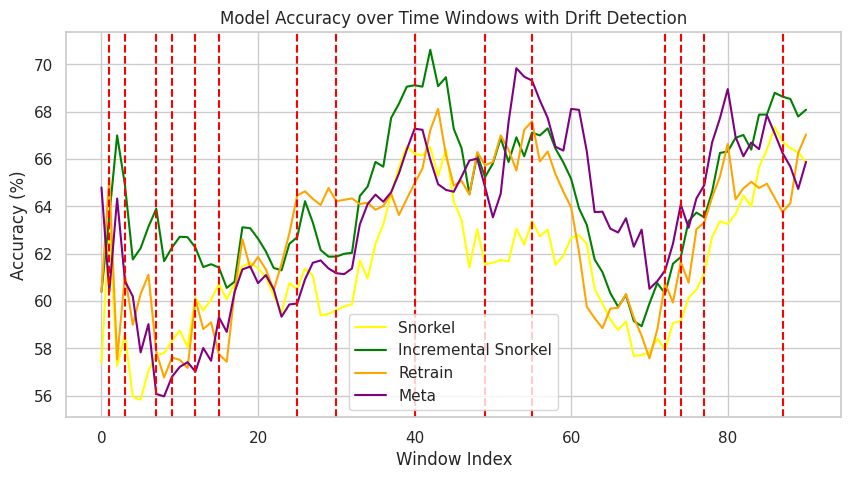

In [83]:
plt.figure(figsize=(10, 5))
plt.plot(snorkel_acc, label='Snorkel', color='yellow')
plt.plot(inc_snorkel_acc, label='Incremental Snorkel', color='green')
plt.plot(retrain_snorkel_acc, label='Retrain', color='orange')
plt.plot(meta_acc, label='Meta', color='purple')

def avg(arr):
    return sum(arr) / len(arr)

print(f"Orig: {avg(snorkel_acc)}")
print(f"Inc: {avg(inc_snorkel_acc)}")
print(f"Retrain: {avg(retrain_snorkel_acc)}")
print(f"Meta: {avg(meta_acc)}")

for drift_idx in list(drifts):
    plt.axvline(x=drift_idx, color='red', linestyle='--')

plt.xlabel('Window Index')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy over Time Windows with Drift Detection')
plt.legend()
plt.grid(True)
plt.show()

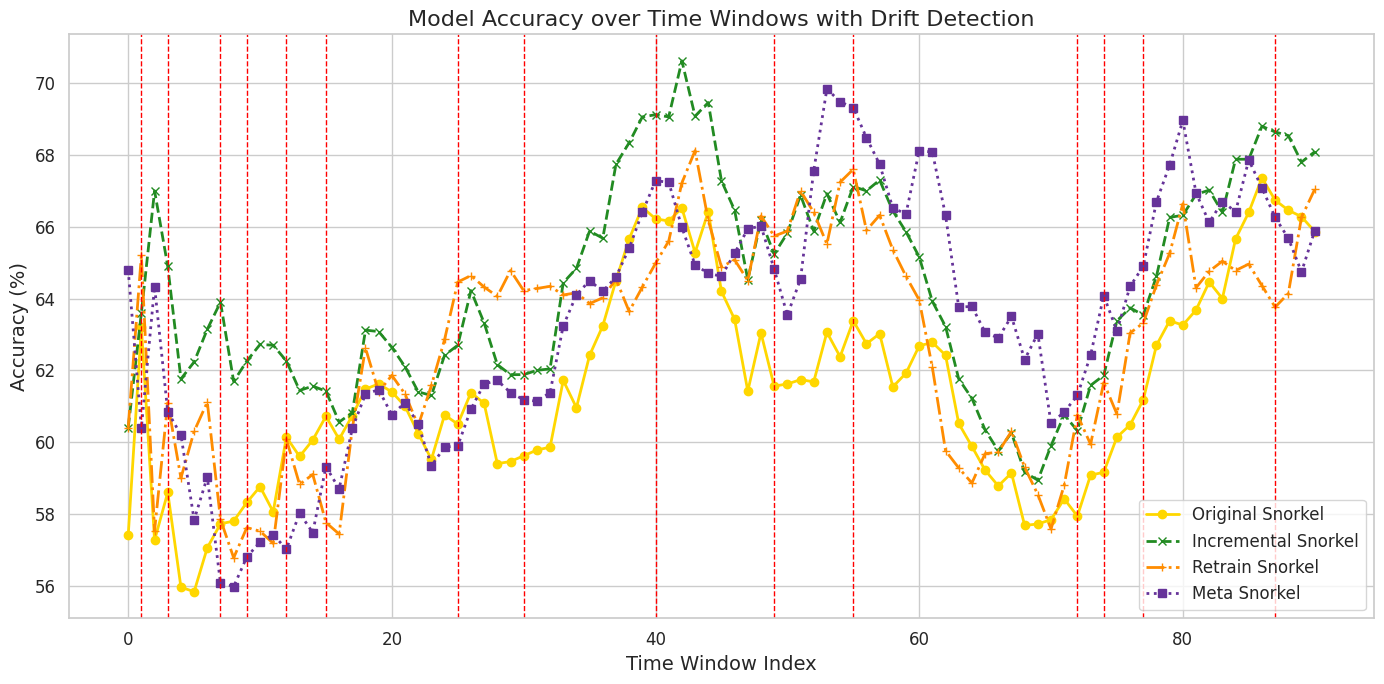

Orig: 61.52
Inc: 64.32
Retrain: 62.80
Meta: 63.42


In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(14, 7))
plt.plot(snorkel_acc, label='Original Snorkel', color='gold', linestyle='-', linewidth=2, marker='o')
plt.plot(inc_snorkel_acc, label='Incremental Snorkel', color='forestgreen', linestyle='--', linewidth=2, marker='x')
plt.plot(retrain_snorkel_acc, label='Retrain Snorkel', color='darkorange', linestyle='-.', linewidth=2, marker='+')
plt.plot(meta_acc, label='Meta Snorkel', color='rebeccapurple', linestyle=':', linewidth=2, marker='s')

for drift_idx in list(drifts):
    plt.axvline(x=drift_idx, color='red', linestyle='--', linewidth=1)

plt.xlabel('Time Window Index', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Model Accuracy over Time Windows with Drift Detection', fontsize=16)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

print(f"Orig: {avg(snorkel_acc):.2f}")
print(f"Inc: {avg(inc_snorkel_acc):.2f}")
print(f"Retrain: {avg(retrain_snorkel_acc):.2f}")
print(f"Meta: {avg(meta_acc):.2f}")


In [88]:
def compute_change(drift_idx, acc_arr):
    return acc_arr[drift_idx - 1] - acc_arr[drift_idx]

for drift_idx in list(drifts):
    print(f"Drift: {drift_idx}, change for original snorkel: {compute_change(drift_idx, snorkel_acc)}")
    print(f"Drift: {drift_idx}, change for incremental snorkel: {compute_change(drift_idx, inc_snorkel_acc)}")
    print(f"Drift: {drift_idx}, change for retrain snorkel: {compute_change(drift_idx, retrain_snorkel_acc)}")
    print(f"Drift: {drift_idx}, change for meta snorkel: {compute_change(drift_idx, meta_acc)}")

Drift: 1, change for original snorkel: -5.800000000000004
Drift: 1, change for incremental snorkel: -3.1999999999999957
Drift: 1, change for retrain snorkel: -4.800000000000004
Drift: 1, change for meta snorkel: 4.3999999999999915
Drift: 3, change for original snorkel: -1.3333333333333286
Drift: 3, change for incremental snorkel: 2.0999999999999943
Drift: 3, change for retrain snorkel: -3.56666666666667
Drift: 3, change for meta snorkel: 3.483333333333327
Drift: 7, change for original snorkel: -0.6678571428571445
Drift: 7, change for incremental snorkel: -0.7571428571428527
Drift: 7, change for retrain snorkel: 3.2642857142857125
Drift: 7, change for meta snorkel: 2.953571428571429
Drift: 40, change for original snorkel: 0.3199999999999932
Drift: 40, change for incremental snorkel: -0.060000000000016485
Drift: 40, change for retrain snorkel: -0.6599999999999966
Drift: 40, change for meta snorkel: -0.8799999999999955
Drift: 9, change for original snorkel: -0.5200000000000031
Drift: 9, c

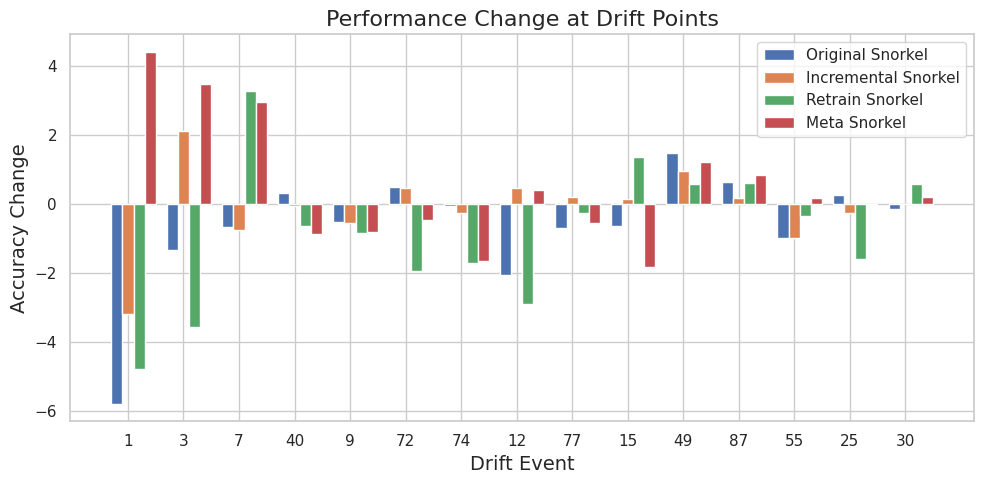

Orig: -0.66
Inc: -0.12
Retrain: -0.82
Meta: 0.49


In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'drifts' is a list of indices where drifts were detected
# and 'snorkel_acc', 'inc_snorkel_acc', 'retrain_snorkel_acc', 'meta_acc' are the respective accuracies

# Compute the change for each strategy at each drift point
orig_changes = [compute_change(drift_idx, snorkel_acc) for drift_idx in drifts]
inc_changes = [compute_change(drift_idx, inc_snorkel_acc) for drift_idx in drifts]
retrain_changes = [compute_change(drift_idx, retrain_snorkel_acc) for drift_idx in drifts]
meta_changes = [compute_change(drift_idx, meta_acc) for drift_idx in drifts]

# Set up the bar width and positions
bar_width = 0.2
r1 = np.arange(len(drifts))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the bar plot
plt.figure(figsize=(10, 5))
plt.bar(r1, orig_changes, width=bar_width, label='Original Snorkel')
plt.bar(r2, inc_changes, width=bar_width, label='Incremental Snorkel')
plt.bar(r3, retrain_changes, width=bar_width, label='Retrain Snorkel')
plt.bar(r4, meta_changes, width=bar_width, label='Meta Snorkel')

# Add labels and title
plt.xlabel('Drift Event', fontsize=14)
plt.ylabel('Accuracy Change', fontsize=14)
plt.xticks([r + bar_width for r in range(len(drifts))], drifts)
plt.title('Performance Change at Drift Points', fontsize=16)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

print(f"Orig: {avg(orig_changes):.2f}")
print(f"Inc: {avg(inc_changes):.2f}")
print(f"Retrain: {avg(retrain_changes):.2f}")
print(f"Meta: {avg(meta_changes):.2f}")

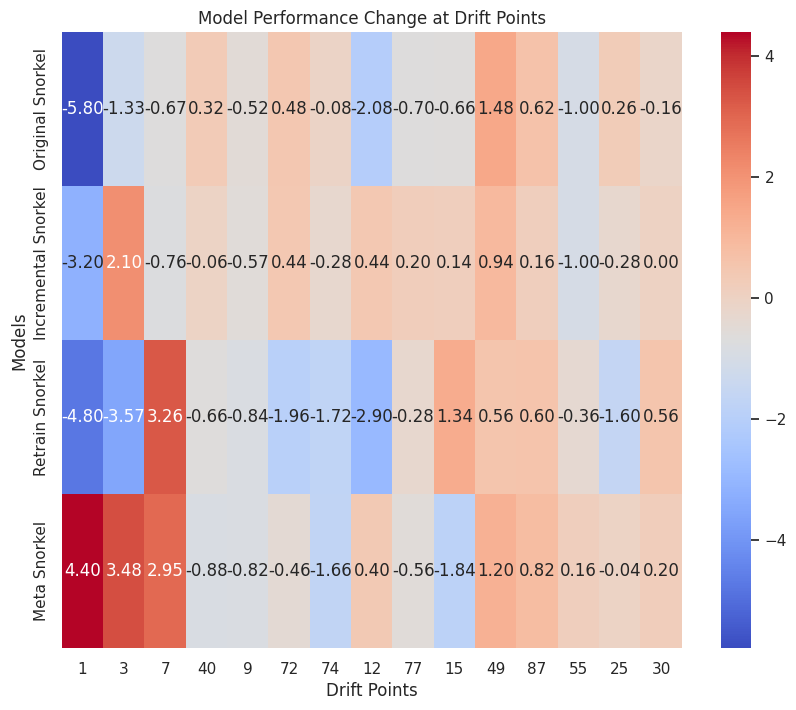

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

changes_matrix = np.array([
    [compute_change(drift_idx, orig_snorkel_acc) for drift_idx in drifts],
    [compute_change(drift_idx, inc_snorkel_acc) for drift_idx in drifts],
    [compute_change(drift_idx, retrain_snorkel_acc) for drift_idx in drifts],
    [compute_change(drift_idx, meta_acc) for drift_idx in drifts]
])

models = ['Original Snorkel', 'Incremental Snorkel', 'Retrain Snorkel', 'Meta Snorkel']

plt.figure(figsize=(10, 8))
sns.heatmap(changes_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=drifts, yticklabels=models)
plt.title('Model Performance Change at Drift Points')
plt.xlabel('Drift Points')
plt.ylabel('Models')
plt.show()


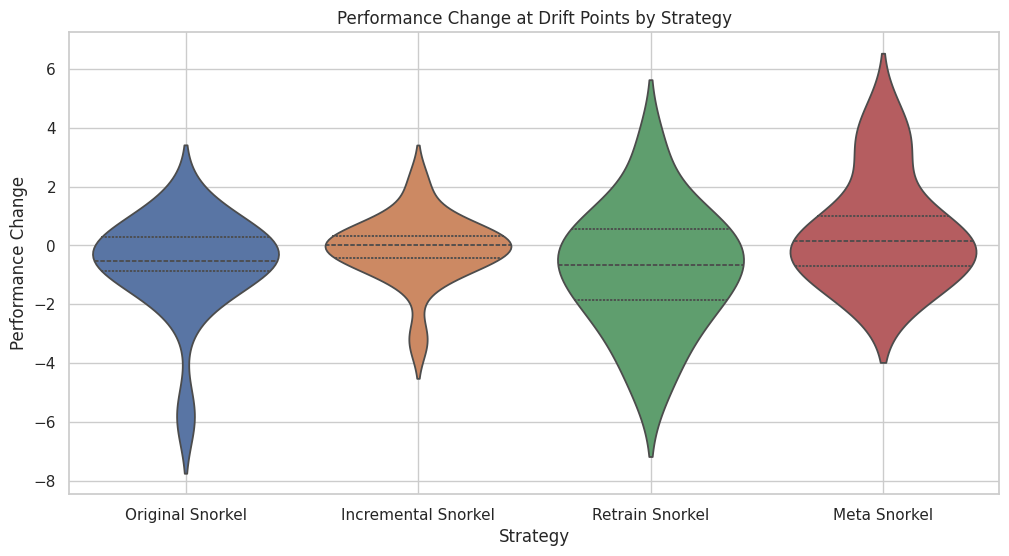

In [92]:
change_data = {
    'Original Snorkel': [compute_change(drift_idx, orig_snorkel_acc) for drift_idx in drifts],
    'Incremental Snorkel': [compute_change(drift_idx, inc_snorkel_acc) for drift_idx in drifts],
    'Retrain Snorkel': [compute_change(drift_idx, retrain_snorkel_acc) for drift_idx in drifts],
    'Meta Snorkel': [compute_change(drift_idx, meta_acc) for drift_idx in drifts]
}

change_df = pd.DataFrame.from_dict(change_data)

plt.figure(figsize=(12, 6))
sns.violinplot(data=change_df, inner="quart", linewidth=1.3)
plt.title('Performance Change at Drift Points by Strategy')
plt.ylabel('Performance Change')
plt.xlabel('Strategy')
plt.grid(True)
plt.show()